In [1]:
%load_ext autoreload

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [6]:
# import data and create trainloader
class Cropper:
    def __call__(self, img):
        return transforms.functional.crop(img, 35, 54, 218, 336)
    
img_scale = 2

transform =  transforms.Compose(
    [
        transforms.Grayscale(),
        Cropper(),
        transforms.Resize((218 // img_scale, 336 // img_scale)),
        transforms.ToTensor(),
    ]
)

test_dataset = datasets.ImageFolder(
    "data/test",
    transform=transform
)

test_data = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
test_labels = torch.Tensor([test_dataset[i][1] for i in range(len(test_dataset))])

In [14]:
# construct CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 20, 5)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)
        self.fc1 = nn.Linear(41760, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn(self.conv1(x))))
        res1 = x.view(x.shape[0], -1).clone()
        x = self.pool(F.relu(self.bn(self.conv2(x))))
        res2 = x.view(x.shape[0], -1).clone()
        x = self.pool2(F.relu(self.bn(self.conv3(x))))
        res3 = x.view(x.shape[0], -1)
        x = F.relu(self.bn(self.conv4(x)))
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, res1, res2, res3), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
model = ConvNet()
model.load_state_dict(torch.load('torch_model.pth'))
model.eval()

ConvNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=41760, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [63]:
def make_saliencies(image, label):
    image.requires_grad_()

    output = model(image.reshape(1, 1, 109, 168))

    label_output = output[0, int(test_labels[0])]
    max_output = output[0, output.argmax()]

    try:
        image.grad.zero_()
    except AttributeError:
        pass
    label_output.backward(retain_graph=True)
    label_saliency = image.grad.data.abs().reshape(109, 168)
    
    try:
        image.grad.zero_()
    except AttributeError:
        pass
    max_output.backward(retain_graph=True)
    max_saliency = image.grad.data.abs().reshape(109, 168)
    
    return label_saliency, max_saliency

In [44]:
label_output.backward()

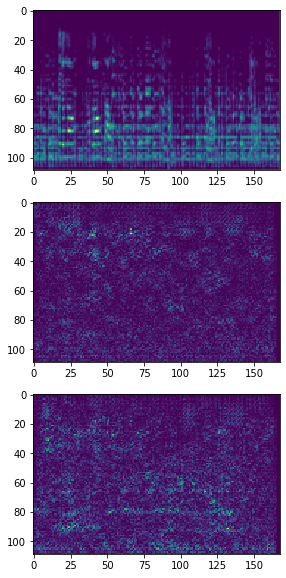

In [61]:
fig, axs = plt.subplots(3, 1, squeeze=True, figsize=(10, 10))
axs[0].imshow(image.detach().reshape(109, 168))
axs[1].imshow(label_saliency.reshape(109, 168))
axs[2].imshow(max_saliency.reshape(109, 168))

In [79]:
sals_from_label = {i: list() for i in range(10)}
for i in range(len(test_data)):
    print(i)
    sals_from_label[int(test_labels[i])].append(make_saliencies(test_data[i], test_labels[i])[0])
    # orch.sum([make_saliencies(test_data[i], test_labels[i])[0] for i in range(len(test_data))])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


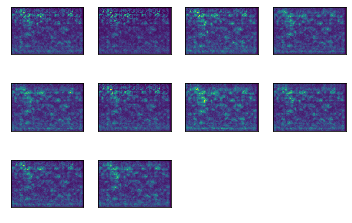

In [91]:
fig, axs = plt.subplots(3, 4, squeeze=True)
for i in range(10):
    axs[i // 4, i % 4].imshow(torch.sum(torch.stack(sals_from_label[i]), dim=0))
    axs[i // 4, i % 4].xaxis.set_visible(False)
    axs[i // 4, i % 4].yaxis.set_visible(False)
for i in [10, 11]:
    axs[i // 4, i % 4].axis('off')

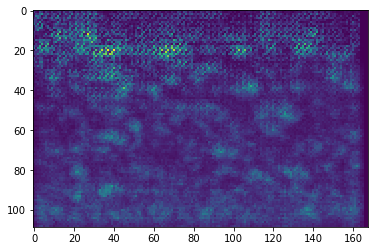

In [76]:
plt.imshow(torch.sum(torch.stack(sals1), dim=0))